# Note:

In [1]:
# path to user functions
import sys  
sys.path.append('../Src/')

from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib 
from sklearn.preprocessing import OrdinalEncoder

# import user functions
import UserUtilityFunctions as uf
import UserVisualization as uv
import UserMetricsFunctions as umf

# set seaborn theme
sns.set_theme()

# initializing variables
RANDOM_STATE = 1776

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20


### Import Dataset
- `df`   -> The 3-year survival binary classification for candidate and donor with scaled features with discretization and all `NaN`  was created in the `Unknown` category. Excluding any Max Gini Impurity < 5% on every feature after all encoding.

In [2]:
# import discretized data
df = pd.read_pickle("../Data/6Clean_ML_Heart_CAT.pkl")
df_ordinal = pd.read_pickle("../Data/6Clean_ML_ordinal.pkl")
df_nominal = pd.read_pickle("../Data/6Clean_ML_nominal.pkl")
df_can = pd.read_pickle("../Data/6Clean_ML_CAN.pkl")
df_don = pd.read_pickle("../Data/6Clean_ML_DON.pkl")
df_both = pd.read_pickle("../Data/6Clean_ML_BOTH.pkl")
df_label = pd.read_pickle("../Data/6Clean_ML_label.pkl")
# print shape
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")
print(f"Nominal Features: {df_nominal.shape[0]:,}")
print(f"Ordinal Features: {df_ordinal.shape[0]:,}")
print(f"Candidate Features: {df_can.shape[0]:,}")
print(f"Donor Features: {df_don.shape[0]:,}")
print(f"Both Features: {df_both.shape[0]:,}")
print(f"Label Features: {df_label.shape[0]:,}")

Heart Dataset Rows: 27,494 & Columns: 108
Nominal Features: 50
Ordinal Features: 55
Candidate Features: 36
Donor Features: 51
Both Features: 18
Label Features: 2


###  Display NaNs

In [3]:
# display NaNs
uf.percentageNull(df)

,percentage,NaNCount
LengthOfStay,3.226158,887
Survival,1.545792,425
TransplantSurvivalDay,1.545792,425


### Drop Unwanted Label Features

#### User Function(s)

In [4]:
def HouseKeeping(data, removeColLst, dataLabel, dataOrdinal, dataNominal, display=True):
    """
    Run helper fuction for house keeping
    """
    # remove DataFrame data (house keeping)
    dataLabel = uf.removeRowUsingMask(dataLabel, removeColLst, colstr='column', string='df_label', display=display)
    dataOrdinal = uf.removeRowUsingMask(dataOrdinal, removeColLst, colstr='column',  string='df_ordinal', display=display)
    dataNominal = uf.removeRowUsingMask(dataNominal, removeColLst, colstr='column', string='df_nominal',  display=display)

    # remove features
    data = uf.removeColumn(data, removeColLst, display=display)

    # return new dataframes
    return data, dataLabel, dataOrdinal, dataNominal

In [5]:
# combine two lists
allCat = df_ordinal.column.to_list() + df_nominal.column.to_list()

# insanity check
uf.symmetricDifference(set(allCat), set(df.columns.to_list()))

Symmetric difference: ['LengthOfStay', 'Survival', 'TransplantSurvivalDay']


#### Survival Plot

Heart Dataset Rows: 27,069 & Columns: 108


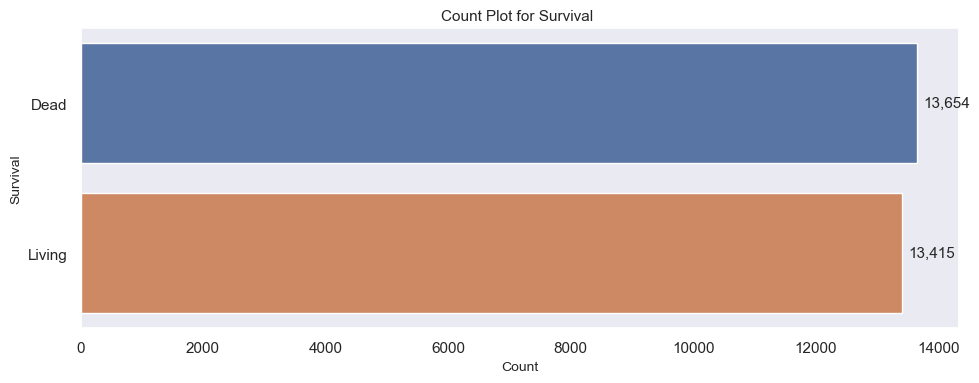

In [6]:
# remove rows where Survival is NaN
df = df.dropna(subset=['Survival'])
# print
print(f"Heart Dataset Rows: {df.shape[0]:,} & Columns: {df.shape[1]:,}")

# plot
uv.countPlot(df, ['Survival'], figsize=(10, 4))

#### Remove Unwanted Label Features

In [7]:
# add to removeCols list
removeCols = df_label.column.to_list()

# remove features
df, df_label, df_ordinal, df_nominal = HouseKeeping(df, removeCols, df_label, df_ordinal, df_nominal, display=True)

Remove 2 row(s) from df_label DataFrame.
Remove 0 row(s) from df_ordinal DataFrame.
Remove 0 row(s) from df_nominal DataFrame.

Removed Features: ['LengthOfStay', 'TransplantSurvivalDay']

Total Row(s) & Column(s) Before Removing Column(s): 27,069 & columns: 108
Total Row(s) & Column(s) After Removing Column(s): 27,069 & columns: 106


### Dummy Encoding

In [8]:
# encode
df_dummy = pd.get_dummies(df, columns=df_nominal.column.to_list(), drop_first=True)
# print shape
print(f"Shape: {df_dummy.shape}")
# add columns to list
dummyCols = df_dummy.columns.tolist()
# remove label
dummyCols.remove('Survival')

Shape: (27069, 220)


#### Display GINI Information

In [9]:
# remove features with GiniPercent
percent = 5
holdDF = uf.computeEntropyGiniImpurity(df_dummy[dummyCols])
removeCols = holdDF.ColumnName[holdDF.GiniPercent < percent].to_list()
print(f"Number of Features to be removed: {len(removeCols)}")
holdDF.sample(20)

Number of Features to be removed: 66


,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
215,BloodPH_CAT_DON_Normal,2,0.971625,1.000000,97.162510,0.480461,0.500000,96.092262
130,StatusAtTransplant_CAN_Other left Heart Valvar/Structural Hypoplasia; Truncus Arteriosus; Congenitally Corrected Transposition,2,0.116125,1.000000,11.612542,0.030765,0.500000,6.153015
188,PulmonaryCatheter_DON_Yes,2,0.326837,1.000000,32.683749,0.112531,0.500000,22.506155
164,EpsteinBarrSeroStatusTransplant_CAN_Unknown,2,0.364152,1.000000,36.415238,0.129384,0.500000,25.876863
171,AntibodyResultHBSAB_DON_Positive,2,0.315429,1.000000,31.542911,0.107506,0.500000,21.501277
37,Dialysis_Yes_Count_CAN,3,0.336196,1.584963,21.211580,0.102932,0.666667,15.439781
120,IntropicMedicationProcurement_DON_Unknown,2,0.031856,1.000000,3.185621,0.006554,0.500000,1.310833
21,Hemodynamics_Mean_PA_MN_CAT_CAN,5,1.498874,2.321928,64.553005,0.590751,0.800000,73.843832
49,Malignancy_Yes_Count_CAN,3,0.439008,1.584963,27.698295,0.162388,0.666667,24.358270
126,StatusAtTransplant_CAN_Hypoplastic Left Heart Syndrome; Atrioventricular Septal Defect; Other left Heart Valvar/Structural,2,0.984119,1.000000,98.411925,0.489033,0.500000,97.806550


In [10]:
# features to be removed
holdDF[holdDF.ColumnName.isin(removeCols)].sample(10)

,ColumnName,NumberOfCategories,Entropy,MaxEntropy,EntropyPercent,GiniImpurity,MaxGiniImpurity,GiniPercent
110,InfectionTherapyIV_CAN_Unknown,2,0.095693,1.0,9.569349,0.024301,0.5,4.860223
183,TriiodothyronineT3_DON_Unknown,2,0.021758,1.0,2.175774,0.004203,0.5,0.840518
143,Ethnicity_DON_Native Hawaiian/other Pacific Islander,2,0.020768,1.0,2.076837,0.003982,0.5,0.796369
122,CigaretteUse_CAN_Unknown,2,0.009134,1.0,0.913434,0.001550,0.5,0.310077
95,PrimaryDiagnosisType_CAN_MUSCULAR DYSTROPHY: OTHER SPECIFY,2,0.007977,1.0,0.797737,0.001329,0.5,0.265810
205,MyocardialInfarctionHistory_DON_Unknown,2,0.077669,1.0,7.766901,0.018881,0.5,3.776142
173,AntibodyResultRPR_VDRL_DON_Positive,2,0.055511,1.0,5.551091,0.012628,0.5,2.525503
89,PrimaryDiagnosisType_CAN_HEART RE-TX/GF: HYPERACUTE REJECTION,2,0.000597,1.0,0.059725,0.000074,0.5,0.014777
87,PrimaryDiagnosisType_CAN_HEART RE-TX/GF: CHRONIC REJECTION,2,0.040748,1.0,4.074837,0.008754,0.5,1.750739
120,IntropicMedicationProcurement_DON_Unknown,2,0.031856,1.0,3.185621,0.006554,0.5,1.310833


### Split Dataset

In [11]:
from sklearn.model_selection import train_test_split

# encoded DataFrame
df_dummy = df_dummy.drop(columns=removeCols)
# print shape
print(f"Heart Dataset Rows: {df_dummy.shape[0]:,} & Columns: {df_dummy.shape[1]:,}")

# house keeping
ordinalCols = list(set(df_ordinal.column.to_list()) - set(removeCols))

# split X & y
X = df_dummy.drop(columns = 'Survival')
y = df_dummy.Survival

# mapping values
y = y.map({'Dead': True, 'Living': False})

# split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

Heart Dataset Rows: 27,069 & Columns: 154


### Scale

In [12]:
from sklearn.preprocessing import MinMaxScaler

# initialize MinMaxScaler
scale = MinMaxScaler()

# fit
fitScale = scale.fit(X_train[ordinalCols])

# transform
X_train[ordinalCols] = fitScale.transform(X_train[ordinalCols])
X_test[ordinalCols] = fitScale.transform(X_test[ordinalCols])

In [13]:
# train describe
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PreviousTransplantNumber_CAN,21655.0,0.011514,0.064316,0.0,0.000000,0.000000,0.000000,1.0
EducationLevel_CAN,21655.0,0.633718,0.210179,0.0,0.500000,0.666667,0.833333,1.0
FunctionalStatusTransplant_CAN,21655.0,0.406996,0.246675,0.0,0.200000,0.400000,0.600000,1.0
MedicalConditionTransplant_CAN,21655.0,0.639252,0.306521,0.0,0.333333,0.666667,1.000000,1.0
MismatchLevel_AMIS,21655.0,0.747172,0.299548,0.0,0.666667,0.666667,1.000000,1.0
MismatchLevel_BMIS,21655.0,0.824783,0.295604,0.0,0.666667,1.000000,1.000000,1.0
MismatchLevel_DRMIS,21655.0,0.763457,0.297461,0.0,0.666667,1.000000,1.000000,1.0
MismatchLevel_HLMIS,21655.0,0.738767,0.266527,0.0,0.714286,0.857143,0.857143,1.0
Age_CAT_CAN,21655.0,0.480974,0.410007,0.0,0.000000,0.500000,1.000000,1.0
Age_CAT_DON,21655.0,0.484715,0.416947,0.0,0.000000,0.500000,1.000000,1.0


### KNN
- `K-Nearest Neighbors (KNN)`
    - Type: Instance-based learning (lazy learning)
    - Mechanism: Classifies a data point based on the majority class among its k-nearest neighbors.
    - Pros: Simple, intuitive, no training phase.
    - Cons: Computationally expensive during prediction, sensitive to irrelevant features and the choice of k.

In [14]:
# import library
from sklearn.neighbors import KNeighborsClassifier

# define the parameter grid for GridSearchCV
parameters = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [10, 30, 50]
}

# create a KNN model
model = KNeighborsClassifier()

# CV with grid search for Hyper-Parameter tuning
knn_fit = umf.stratified_grid(model, parameters, X_train, y_train, seed=RANDOM_STATE, nJobs=-1, nSplit=5, score='accuracy')

# best model
model = knn_fit.best_estimator_

CV accuracy: 0.754 +/- 0.003


In [15]:
print(model)

KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=7)


#### Metrics

#### Train

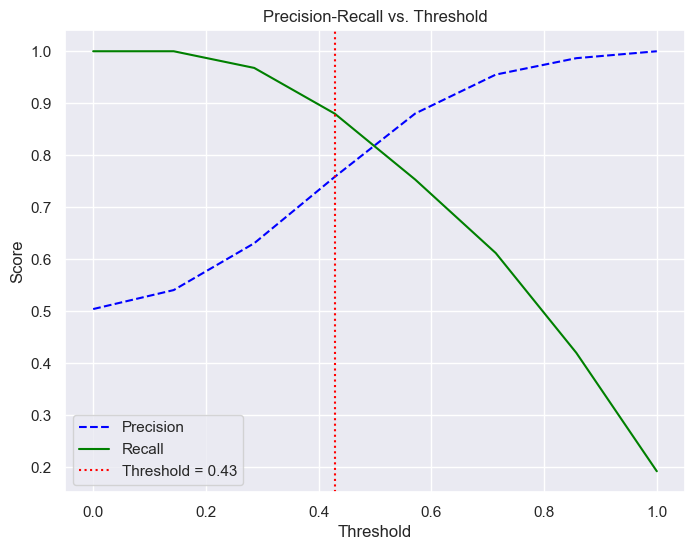

***** Classification Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

       False       0.78      0.90      0.83     10732
        True       0.88      0.75      0.81     10923

    accuracy                           0.82     21655
   macro avg       0.83      0.82      0.82     21655
weighted avg       0.83      0.82      0.82     21655



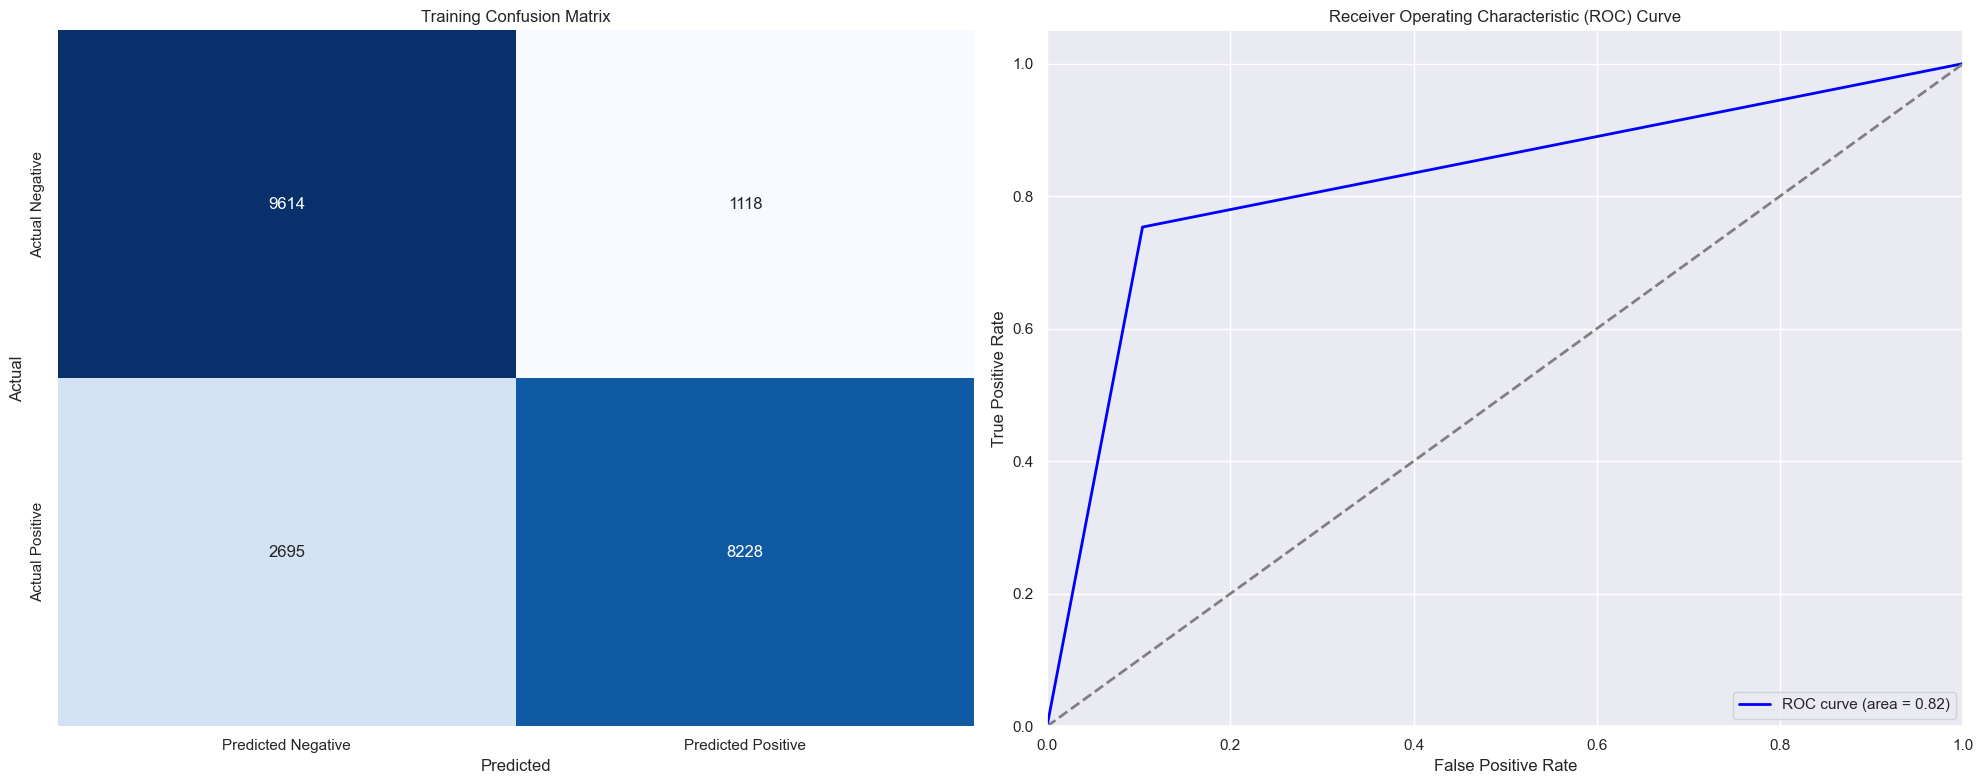

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,KNN,knn_fit,KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Training,0.823921,0.753273,0.81188,0.787615,0.880377,0.895826,0.824549


In [18]:
# initialize variables
Algorithm = 'KNN'
Desc = f'KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < {percent}% removed'
Model = 'knn_fit'
Type = 'Training'

# display
df_classfication, threshold = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train, y_train, Type, metricDF=None, trainThreshold=True)
df_classfication

#### Test

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

       False       0.71      0.82      0.77      2683
        True       0.80      0.68      0.73      2731

    accuracy                           0.75      5414
   macro avg       0.76      0.75      0.75      5414
weighted avg       0.76      0.75      0.75      5414



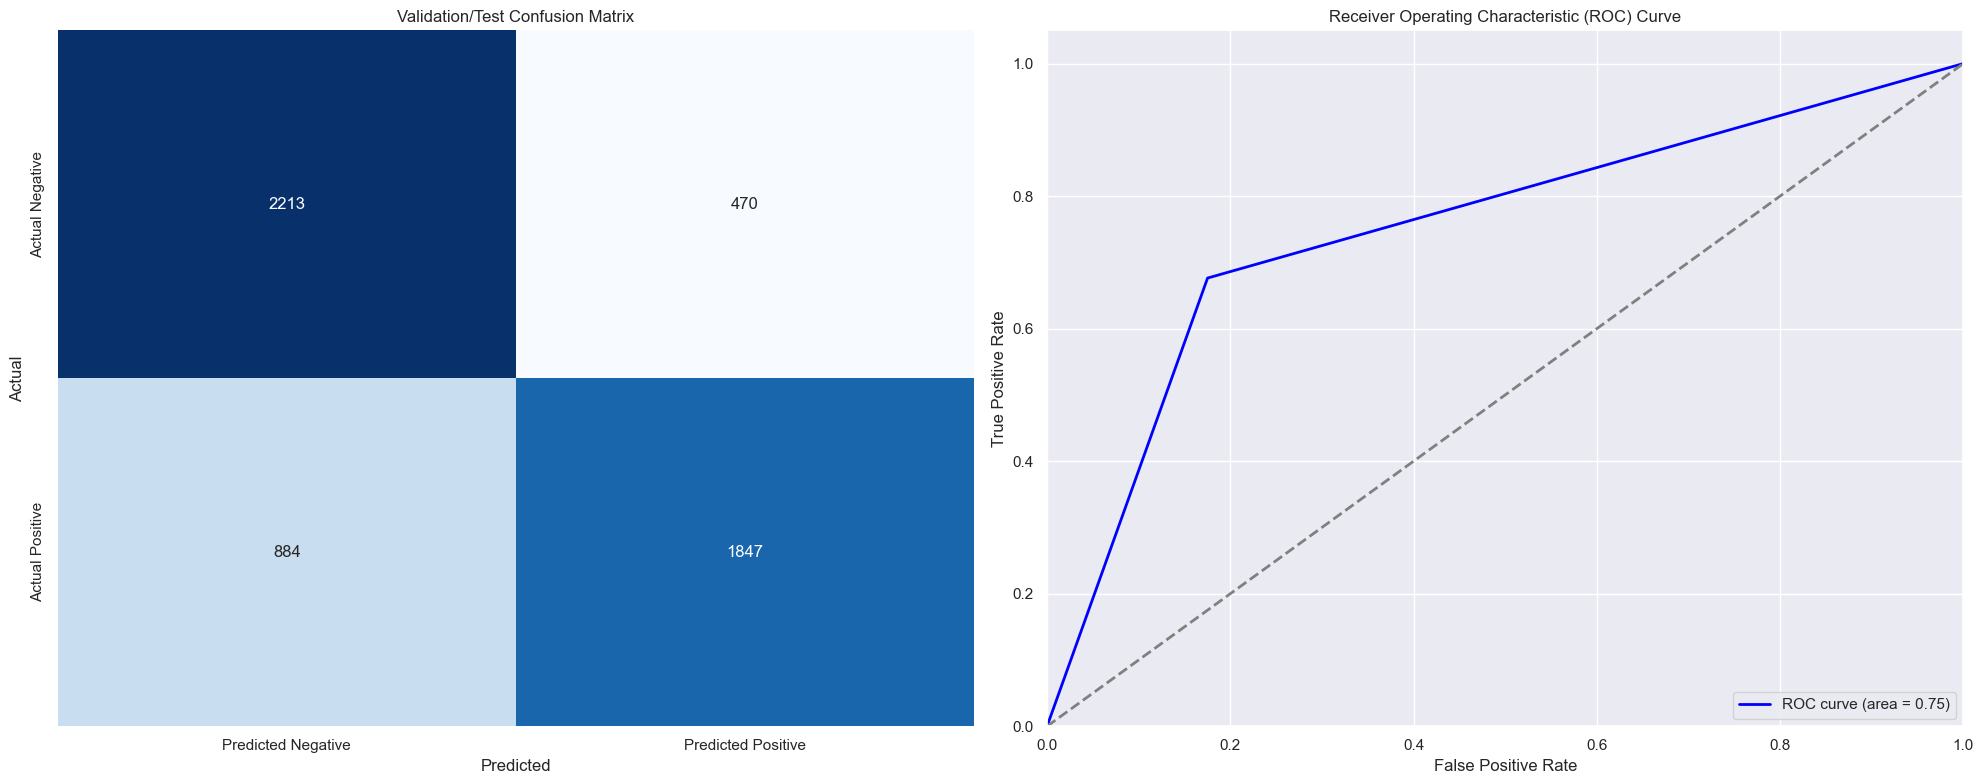

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,KNN,knn_fit,KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Training,0.823921,0.753273,0.811880,0.787615,0.880377,0.895826,0.824549
1,KNN,knn_fit,KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Validation/test,0.749908,0.676309,0.731775,0.702401,0.797151,0.824823,0.750566


In [19]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication, _ = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test, y_test, Type, metricDF=df_classfication, trainThreshold=threshold)
df_classfication

### Save Model to Disk

In [ ]:
import joblib

# save the model to a file
joblib.dump(model, '../Models/KNN_Threshold.joblib')

# load the model from the file
# loaded_model = joblib.load('../Models/KNN_Threshold.joblib')

### Resample Data & Train

In [ ]:
# sample fraction
fraction = .60
# sample from original dataframe 
df_sample = df.sample(frac=fraction, random_state=RANDOM_STATE)

# re-index
df_sample = df_sample.reset_index(drop=True)
# plot
uv.countPlot(df_sample, ['Survival'], figsize=(10, 4))

#### Encode

In [ ]:
# encode
df_dummy_sample = pd.get_dummies(df_sample, columns=df_nominal.column.to_list(), drop_first=True)
# print shape
print(f"Shape: {df_dummy_sample.shape}")
# add columns to list
dummyCols = df_dummy_sample.columns.tolist()
# remove label
dummyCols.remove('Survival')

#### GINI

In [ ]:
# remove features with GiniPercent
percent = 5
holdDF = uf.computeEntropyGiniImpurity(df_dummy_sample[dummyCols])
removeCols = holdDF.ColumnName[holdDF.GiniPercent < percent].to_list()
print(f"Number of Features to be removed: {len(removeCols)}")

#### Split Dataset

In [ ]:
# encoded DataFrame
df_dummy_sample = df_dummy_sample.drop(columns=removeCols)
# print shape
print(f"Heart Dataset Rows: {df_dummy_sample.shape[0]:,} & Columns: {df_dummy_sample.shape[1]:,}")

# house keeping
ordinalCols = list(set(df_ordinal.column.to_list()) - set(removeCols))

# split X & y
X_sample = df_dummy_sample.drop(columns = 'Survival')
y_sample = df_dummy_sample.Survival

# mapping values
y_sample = y_sample.map({'Dead': True, 'Living': False})

# split the dataset into 80% training and 20% testing
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=RANDOM_STATE, stratify=y_sample)

#### Scale

In [ ]:
# initialize MinMaxScaler
scale = MinMaxScaler()

# fit
fitScale = scale.fit(X_train_sample[ordinalCols])

# transform
X_train_sample[ordinalCols] = fitScale.transform(X_train_sample[ordinalCols])
X_test_sample[ordinalCols] = fitScale.transform(X_test_sample[ordinalCols])

#### KNN: Re-Sample

In [ ]:
# define the parameter grid for GridSearchCV: add adtional paramater since smaler dataset
parameters = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [5, 10, 30, 50]
}

# create a KNN model
model = KNeighborsClassifier()

# CV with grid search for Hyper-Parameter tuning
knn_resampled_fit = umf.stratified_grid(model, parameters, X_train_sample, y_train_sample, seed=RANDOM_STATE, nJobs=-1, nSplit=5, score='accuracy')

# best model
model = knn_resampled_fit.best_estimator_

In [ ]:
print(model)

#### Train

In [ ]:
# initialize variables
Algorithm = 'KNN'
Desc = f'KNN - 2011-2016: Re-Sampled @ {fraction * 100}% - Grid Search - Features where Max Gini Impurity < {percent}% removed'
Model = 'knn_resampled_fit'
Type = 'Training'

# display
df_classfication, threshold_sample = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_train_sample, y_train_sample, Type, metricDF=df_classfication, trainThreshold=True)
df_classfication

#### Test

In [ ]:
# initialize variable
Type = 'Validation/Test'

# display
df_classfication, _ = umf.ClassificationMatric(Algorithm, Model, Desc, model, X_test_sample, y_test_sample, Type, metricDF=df_classfication, trainThreshold=threshold_sample)
df_classfication

### Plot

#### User Functiuon(s)

In [ ]:
def predictionThreshold(model, threshold, Xdata):
    # get the best model
    modelBest = model.best_estimator_
    
    # predict probabilities
    probabilities = modelBest.predict_proba(Xdata)

    print(probabilities)
    # define custom threshold
    custom_threshold = threshold
    
    # assign class labels based on the custom threshold
    predictions = (probabilities[:, 1] >= custom_threshold).astype(int)

    return predictions

In [127]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([2225, 3189]))

In [128]:
y_test.value_counts()

Survival
True     2731
False    2683
Name: count, dtype: int64

#### PCA

In [81]:
model = knn_fit.best_estimator_

***** Classification Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7154
           1       1.00      1.00      1.00     19915

    accuracy                           1.00     27069
   macro avg       1.00      1.00      1.00     27069
weighted avg       1.00      1.00      1.00     27069



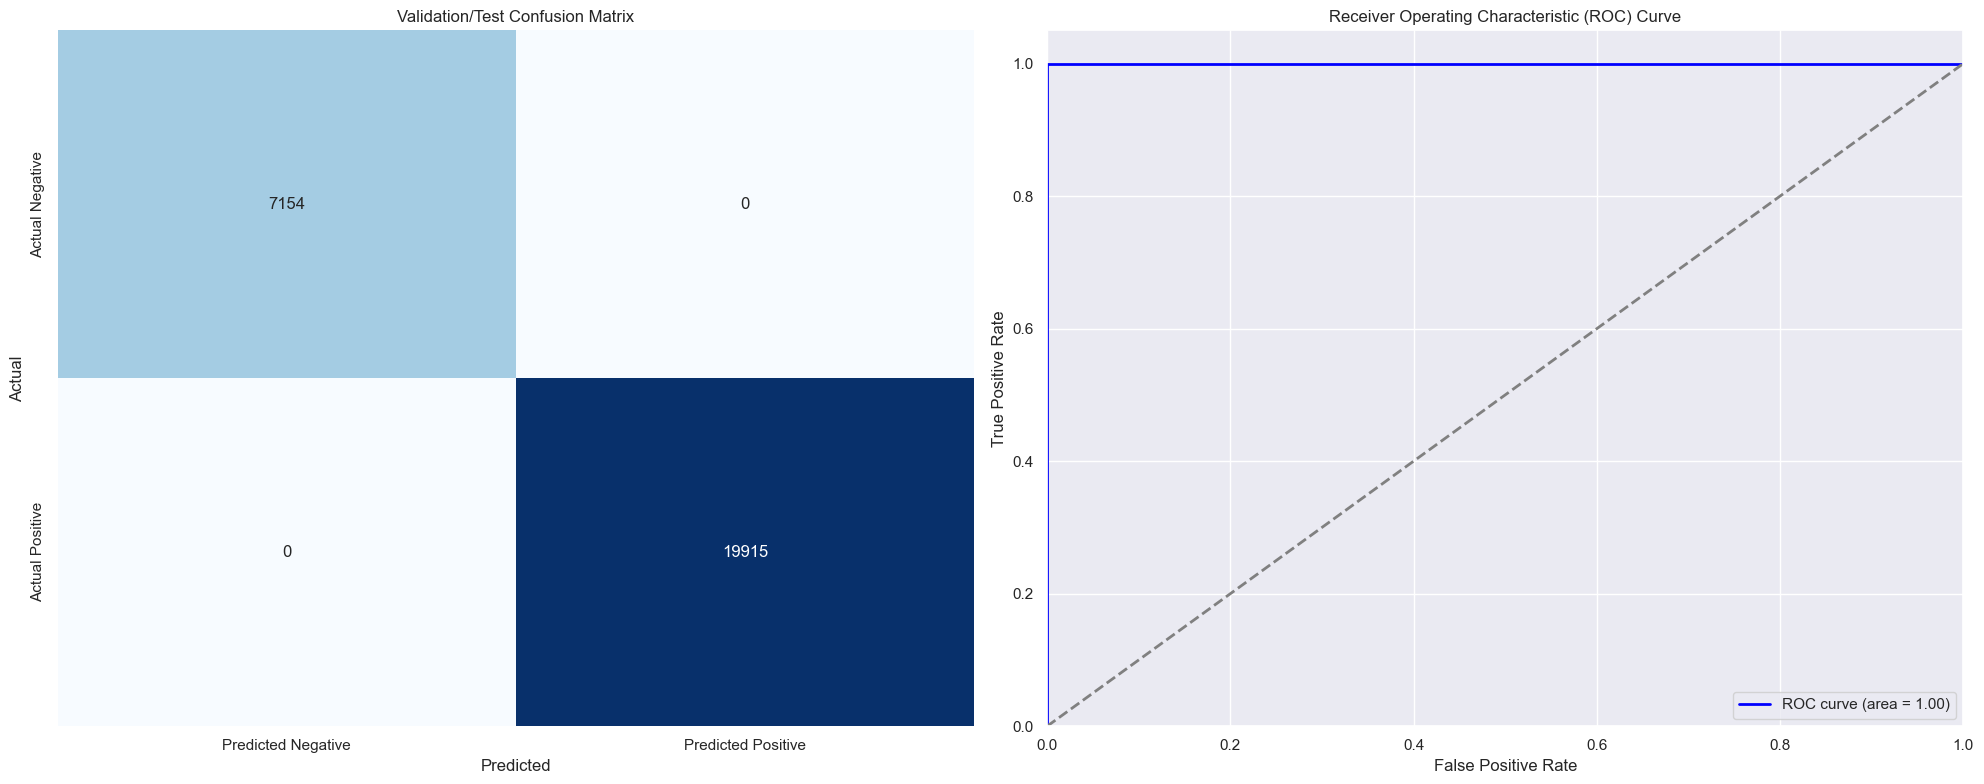

,Algorithm,Model,Description,DataType,Accuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,KNN,knn_fit,KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Training,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,KNN,knn_fit,KNN - 2011-2016: Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Validation/test,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,KNN,knn_resampled_fit,KNN - 2011-2016: Re-Sampled @ 60.0% - Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.444,Training,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,KNN,knn_resampled_fit,KNN - 2011-2016: Re-Sampled @ 60.0% - Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.444,Validation/test,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,KNN,knn_fit,KNN - 2011-2016: Re-Sampled @ 60.0% - Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.556,Entire,0.874912,1.000000,0.862759,0.758643,0.758643,0.793863,0.896932
5,KNN,knn_fit,KNN - 2011-2016: Re-Sampled @ 60.0% - Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Entire,0.853412,0.779519,0.876101,0.926107,1.000000,1.000000,0.889759
6,KNN,knn_fit,KNN - 2011-2016: Re-Sampled @ 60.0% - Grid Search - Features where Max Gini Impurity < 5% removed - Threshold: 0.429,Entire,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [82]:
# initialize variables
Algorithm = 'KNN'
Desc = f'KNN - 2011-2016: Re-Sampled @ {fraction * 100}% - Grid Search - Features where Max Gini Impurity < {percent}% removed'
Model = 'knn_fit'
Type = 'Entire'

# display
df_classfication, _ = umf.ClassificationMatric(Algorithm, Model, Desc, model, X, y, Type, metricDF=df_classfication, trainThreshold=threshold)
df_classfication

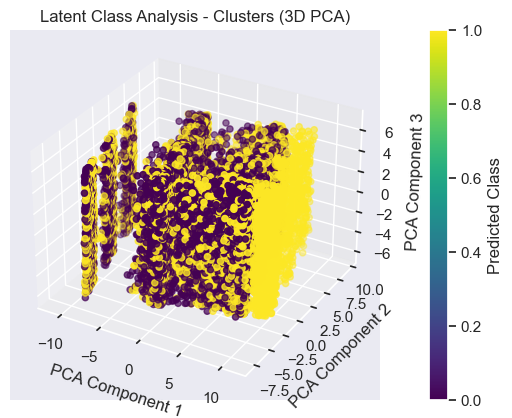

In [83]:
from mpl_toolkits.mplot3d import Axes3D

# prediction
pred = predictionThreshold(knn_fit, threshold, X)
# Optionally, visualize the cluster assignments for the first two features
# Since the number of features is more than 2, you can visualize using PCA or just the first 2 dimensions for simplicity
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')

# Labels and title
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('Latent Class Analysis - Clusters (3D PCA)')

# Color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Predicted Class')

plt.show()


In [89]:
y.value_counts()

Survival
True     13654
False    13415
Name: count, dtype: int64

In [93]:
type(pred),pred.shape

(numpy.ndarray, (27069,))

In [98]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([ 3364, 23705]))

In [110]:
y_train.value_counts()

Survival
True     10923
False    10732
Name: count, dtype: int64

In [109]:
pd.DataFrame(pred).value_counts()

0
1    12673
0     8982
Name: count, dtype: int64

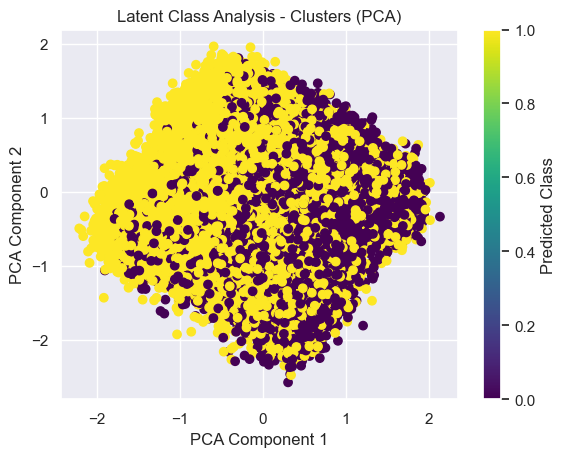

In [106]:
# prediction
pred = predictionThreshold(knn_fit, threshold, X_train)
# Optionally, visualize the cluster assignments for the first two features
# Since the number of features is more than 2, you can visualize using PCA or just the first 2 dimensions for simplicity
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Class Analysis - Clusters (PCA)')
plt.colorbar(label='Predicted Class')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/survival_env/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning:

invalid value encountered in sqrt



AttributeError: module 'matplotlib.pyplot' has no attribute 'zlabel'

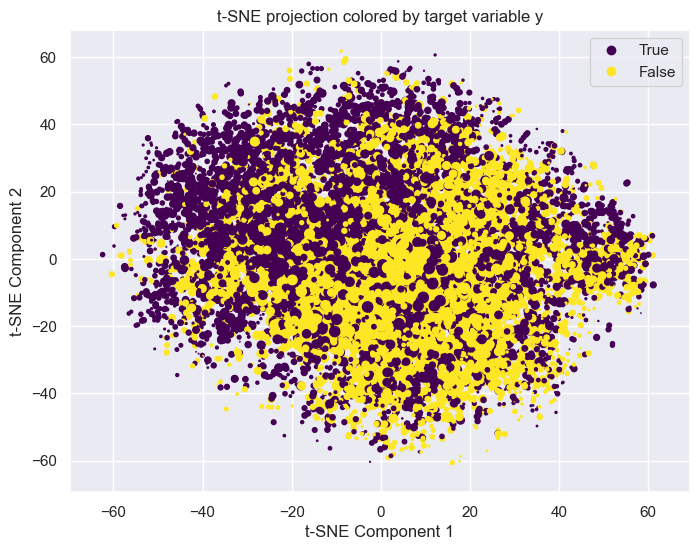

In [108]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components for 2D visualization
tsne = TSNE(n_components=3, random_state=RANDOM_STATE)

# Fit and transform the data
X_embedded = tsne.fit_transform(X_train)

# Creating a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=pd.factorize(y_train)[0], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=list(pd.factorize(y)[1]))
plt.title('t-SNE projection colored by target variable y')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
# plt.zlabel('t-SNE Component 3')
plt.show()

In [111]:
# import plotly.express as px

# # Initialize t-SNE with 3 components for 3D visualization
# tsne = TSNE(n_components=3, random_state=0)

# # Fit and transform the data
# X_embedded = tsne.fit_transform(X_train)

# # Convert to DataFrame for easier handling
# df_tsne = pd.DataFrame(X_embedded, columns=['Component 1', 'Component 2', 'Component 3'])
# df_tsne['Label'] = y_train

# # Creating an interactive 3D scatter plot
# fig = px.scatter_3d(df_tsne, x='Component 1', y='Component 2', z='Component 3', color='Label',
#                     title='t-SNE 3D Projection', labels={'color': 'Label'})
# fig.show()

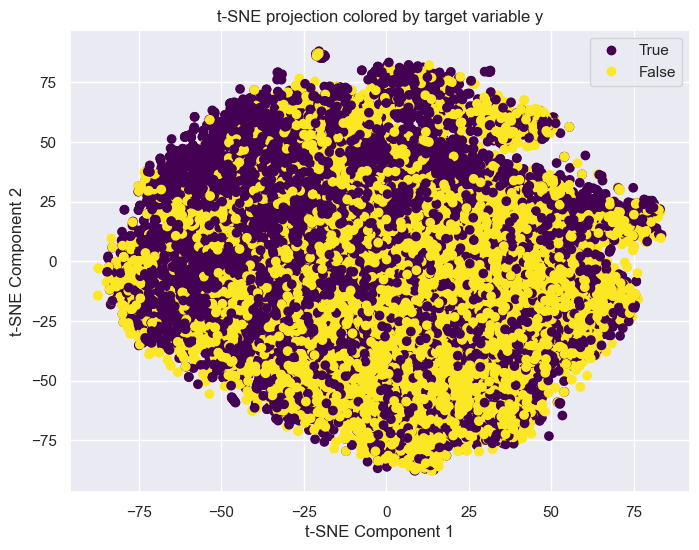

In [105]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components for 2D visualization
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)

# Fit and transform the data
X_embedded = tsne.fit_transform(X_train)

# Creating a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=pd.factorize(y_train)[0], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=list(pd.factorize(y)[1]))
plt.title('t-SNE projection colored by target variable y')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

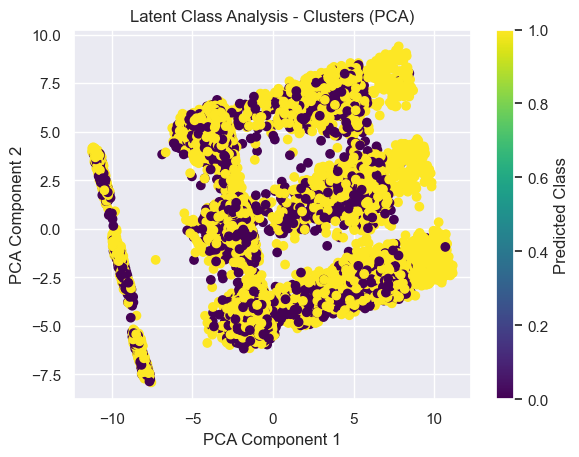

In [35]:
# prediction
pred_sample = predictionThreshold(knn_resampled_fit, threshold_sample, X_sample)
# Optionally, visualize the cluster assignments for the first two features
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pred_sample, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Class Analysis - Clusters (PCA)')
plt.colorbar(label='Predicted Class')
plt.show()

#### FAMD

In [69]:
X.shape, X_sample.shape

((27069, 153), (16241, 153))

In [70]:
import warnings
from pandas.errors import PerformanceWarning
warnings.filterwarnings("ignore", category=PerformanceWarning)

# import library
from prince import FAMD

# initialize FAMD
famd = FAMD(
    n_components=2,             # Number of dimensions to keep
    n_iter=10,                  # Number of iterations for the SVD algorithm
    random_state=RANDOM_STATE,  # For reproducibility
    engine="sklearn"
)

# defrag
X = X.copy()
X_sample = X_sample.copy()

# Fit the model and transform the data
famd_pc_full = famd.fit_transform(X)

# initialize FAMD
famd = FAMD(
    n_components=2,             # Number of dimensions to keep
    n_iter=10,                  # Number of iterations for the SVD algorithm
    random_state=RANDOM_STATE,  # For reproducibility
    engine="sklearn"
)

famd_pc_sample = famd.fit_transform(X_sample)

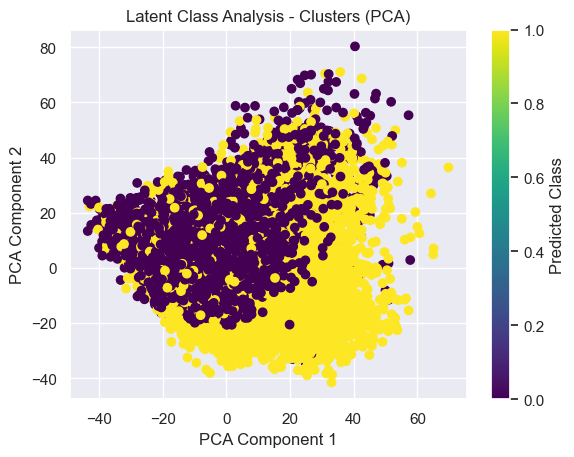

In [99]:
plt.scatter(famd_pc_full[0], famd_pc_full[1], c=y, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Class Analysis - Clusters (PCA)')
plt.colorbar(label='Predicted Class')
plt.show()

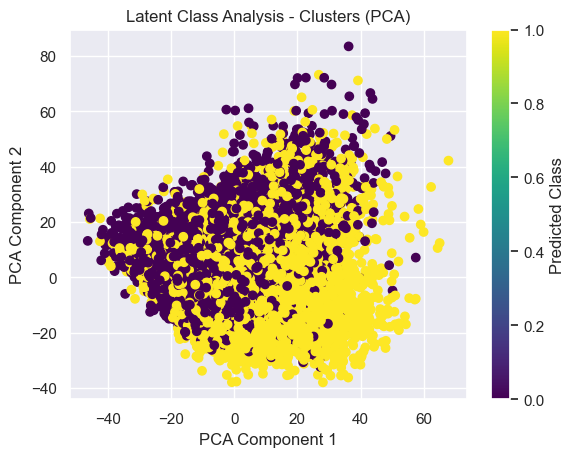

In [72]:
plt.scatter(famd_pc_sample[0], famd_pc_sample[1], c=y_sample, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Latent Class Analysis - Clusters (PCA)')
plt.colorbar(label='Predicted Class')
plt.show()